In [188]:
import pandas as pd
import os
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis, 
                                            QuadraticDiscriminantAnalysis)
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from scipy import stats
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
from statsmodels.sandbox.stats.multicomp import TukeyHSDResults
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier

## Cargamos dataset

In [189]:
# Cargamos dataset Iris
ds = pd.read_csv('iris.data', header=None, names=['largo_sepalo',
                                                  'ancho_sepalo',
                                                  'largo_petalo',
                                                  'ancho_petalo',
                                                  'clase'])

In [190]:
output = 'clase'
y = ds[output].values
X = ds.drop(output,axis=1).values

## Preprocesado de datos

**Comprobamos que no haya "missing values"**  
Dado que no los hay, seguimos adelante.

In [191]:
attr = []
# Iteramos los atributos del dataset
for i in ds.columns:
    # Comprobamos los valores de cada atributo
    attr.append(np.all(ds[i].notna()))
# Ningún atributo tiene missing values:
np.all(np.array(attr))

True

**Comprobamos que no haya variables con "near-zero variance"**  
Vemos que no hay ninguna.

In [192]:
ds.columns.drop(output)[ds.std() < 0.001]

Index([], dtype='object')

**Comprobamos que no haya variables iguales**  
Vemos que no hay ninguna.

In [193]:
resultados = np.zeros((len(ds.columns), len(ds.columns)))
for i in range(len(ds.columns)):
    for j in range(len(ds.columns)):
        resultados[i, j] = np.mean(ds.iloc[:, i] == ds.iloc[:, j])

In [194]:
iguales = []
for i, j in it.combinations(range(len(ds.columns)), 2):
    if round(resultados[i, j], 4) == 1:
        iguales.append(ds.columns[i])
        print(ds.columns[i], ds.columns[j])

**Comprobamos que las clases no estén desbalanceadas**  
No lo están.

In [195]:
y = np.array([i for i,j in enumerate(set(y)) for k in y if j == k])

In [196]:
print('Proporción clase 0: ',np.mean(y==0))
print('Proporción clase 1: ',np.mean(y==1))
print('Proporción clase 2: ',np.mean(y==2))

Proporción clase 0:  0.3333333333333333
Proporción clase 1:  0.3333333333333333
Proporción clase 2:  0.3333333333333333


**Desordenamos los datos**

In [197]:
X,y = shuffle(X,y)

## Detección de Outliers
Visualizamos de distintas formas los posibles outliers  
y vemos que se puede considerar que existen pero son pocos y no los tratamos.

In [198]:
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)

In [199]:
y_pred = clf.fit_predict(X)

In [200]:
X_scores = clf.negative_outlier_factor_

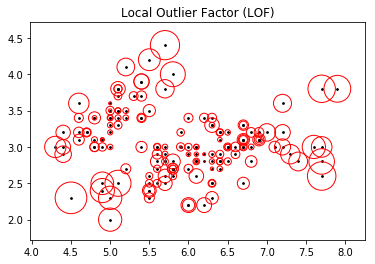

In [201]:
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.show()

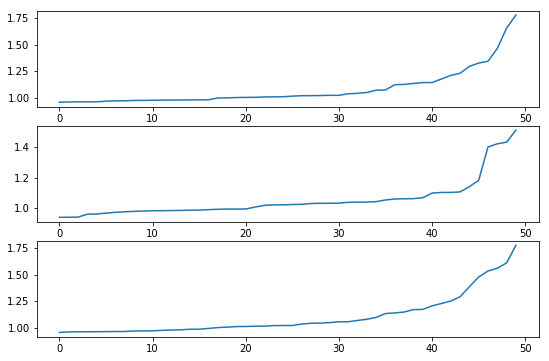

In [202]:
f, ax = plt.subplots(3,1,figsize=(9,6))
for i in set(y):
    temp = X[y == i]
    y_pred = clf.fit_predict(temp)
    temp_scores = clf.negative_outlier_factor_
    ax[i].plot(range(len(temp_scores)),sorted(-temp_scores))

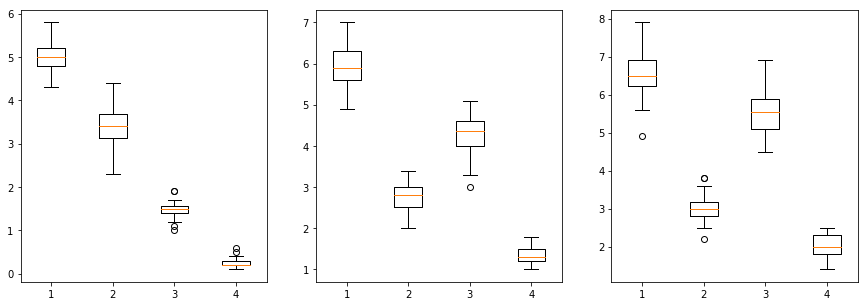

In [203]:
f, ax = plt.subplots(1,3,figsize=(15,5))
for i in set(y):
    temp = X[y == i]
    data = []
    for j in range(X.shape[1]):
        data.append(temp[:,j])
    bp = ax[i].boxplot(data)
plt.show()

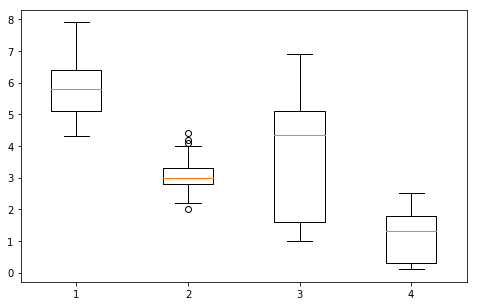

In [204]:
# Create a figure instance
fig = plt.figure(figsize=(8, 5))
# Create an axes instance
ax = fig.add_subplot(111)
data = []
for j in range(X.shape[1]):
    data.append(X[:,j])
bp = ax.boxplot(data)
plt.show()

## Entrenamiento de Modelos

**kFold - Decision Tree Classifier**

In [205]:
kf = KFold(n_splits=10,shuffle=True)
resultados_train = []
resultados_valid = []
model = []
res_train = np.empty((30,0))
res_valid = np.empty((30,0))
test_indices = []
etiquetas = ['DT Normal',
             'DT Profundidad',
             'DT Minimo de muestras por hoja',
             'DT Minimo de muestras en subarbol',
             'DT Minimo de impureza',
             'LDA lsqr',
             'LDA eigen',
             'LDA svd',
             'QDA']
dicc = [{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_impurity_decrease': 0.0},
        {'max_depth': 5,    'min_samples_leaf': 1, 'min_samples_split': 2, 'min_impurity_decrease': 0.0},
        {'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_impurity_decrease': 0.0},
        {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_impurity_decrease': 0.0},
        {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_impurity_decrease': 0.2}]

for i in range(len(dicc)):
    test_indices2 = []
    for j in range(3):
        for train_index, test_index in kf.split(X):
    #         train_test_split del conjunto train y pillar 1/9 para validación
            X_train, X_valid, y_train, y_valid = train_test_split(X[train_index],y[train_index],test_size=1/9)
            test_indices2.append(test_index)
    #         print('X_train: {}\n, X_valid: {}\n, X_test: {}'.format(X_train, X_valid, X_test))
            alg = DecisionTreeClassifier(**dicc[i])
            alg.fit(X_train, y_train)
            model.append(alg)
            resultados_train.append(alg.score(X_train, y_train))
            resultados_valid.append(alg.score(X_valid, y_valid))
    res_train = np.hstack((res_train, np.array(resultados_train,ndmin=2).T))
    res_valid = np.hstack((res_valid, np.array(resultados_valid,ndmin=2).T))
    resultados_train = []
    resultados_valid = []
    test_indices.append(test_indices2)

    
            

**kFold - Linear Discriminant Analysis**

In [206]:
for tipo in ('lsqr', 'eigen', 'svd'):
    test_indices2 = []
    for _ in range(3):
        for train_index, test_index in kf.split(X):
            X_train, X_valid, y_train, y_valid = train_test_split(X[train_index],y[train_index],test_size=1/9)
            alg = LinearDiscriminantAnalysis(solver=tipo, shrinkage=None)
            test_indices2.append(test_index)
            alg.fit(X_train, y_train)
            resultados_train.append(alg.score(X_train, y_train))
            resultados_valid.append(alg.score(X_valid, y_valid))
    res_train = np.hstack((res_train, np.array(resultados_train,ndmin=2).T))
    res_valid = np.hstack((res_valid, np.array(resultados_valid,ndmin=2).T))
    resultados_train = []
    resultados_valid = []
    test_indices.append(test_indices2)
    

**kFold - Quadratic Discriminant Analysis**

In [207]:

test_indices2 = []
for _ in range(3):
    for train_index, test_index in kf.split(X):
        X_train, X_valid, y_train, y_valid = train_test_split(X[train_index],y[train_index],test_size=1/9)
        test_indices2.append(test_index)
        alg = QuadraticDiscriminantAnalysis(priors=np.array([1/3, 1/3, 1/3]))
        alg.fit(X_train, y_train)
        resultados_train.append(alg.score(X_train, y_train))
        resultados_valid.append(alg.score(X_valid, y_valid))
res_train = np.hstack((res_train, np.array(resultados_train,ndmin=2).T))
res_valid = np.hstack((res_valid, np.array(resultados_valid,ndmin=2).T))
test_indices.append(test_indices2)


**Test de normalidad**  
Rechazamos normalidad

In [208]:
np.apply_along_axis(lambda x: stats.shapiro(x)[1], axis=0, arr=res_valid)


array([8.86908092e-05, 7.32303233e-05, 3.69484474e-06, 3.61826766e-04,
       1.44965725e-05, 2.99691266e-07, 5.36529660e-06, 1.01461906e-08,
       7.72824560e-09])

**Test de Kruskal-Wallis**  
Rechazamos que las precisiones sean similares

In [209]:
print(stats.kruskal(*zip(*list(res_valid))))

KruskalResult(statistic=34.22657713365305, pvalue=3.695998114293537e-05)


In [210]:
labels = [str(i) for i in range(res_valid.shape[1]) for _ in range(res_valid.shape[0])]
arr_valid = res_valid.flatten('F')
resultados = pairwise_tukeyhsd(arr_valid,labels)
resultados.summary()

group1,group2,meandiff,lower,upper,reject
0,1,-0.0022,-0.0418,0.0374,False
0,2,0.0267,-0.013,0.0663,False
0,3,-0.0022,-0.0418,0.0374,False
0,4,0.0178,-0.0218,0.0574,False
0,5,0.0378,-0.0018,0.0774,False
0,6,0.0222,-0.0174,0.0618,False
0,7,0.0467,0.007,0.0863,True
0,8,0.0444,0.0048,0.0841,True
1,2,0.0289,-0.0107,0.0685,False
1,3,0.0,-0.0396,0.0396,False


Figure(720x432)


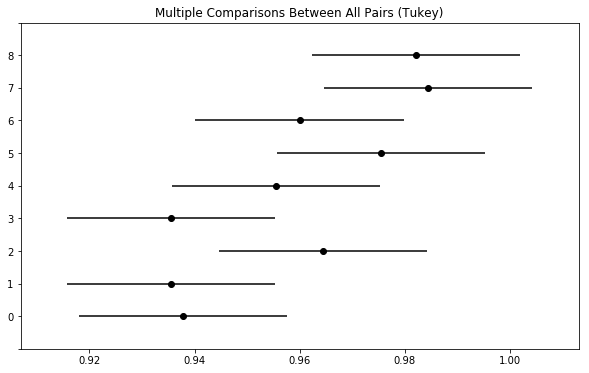

In [211]:
print(resultados.plot_simultaneous())

In [119]:
#seleccionamos el que tiene mejor media y vemos en el anterior cuales son iguales
best_group = np.argmax(np.mean(res_valid, axis = 0))
etiquetas[best_group]

'LDA lsqr'

In [120]:
resultados = resultados._results_table.data

In [121]:
group1 = resultados[0].index('group1')
group2 = resultados[0].index('group2')
reject = resultados[0].index('reject')
best_groups = []
for row in resultados[1:]:
    if (row[group1] == str(best_group) or row[group2] == str(best_group)) and not row[reject]:
        best_groups.append(row[group1])
        best_groups.append(row[group2])
best_groups = set(best_groups)
sorted([etiquetas[int(i)] for i in best_groups])

['DT Minimo de muestras en subarbol',
 'DT Minimo de muestras por hoja',
 'DT Normal',
 'DT Profundidad',
 'LDA eigen',
 'LDA lsqr',
 'LDA svd',
 'QDA']

In [ ]:
#TODO: Aclarar como hacer el test final y la matriz de confusión.

**Nos quedamos con el más sencillo**  
El cual asumimos que es el Lineal Discriminant Analysis con lsqr (mínimos cuadrados)

In [233]:
def performance_indexes(CM, PositiveClass):
    classNum = len(CM)
    TP = CM[PositiveClass, PositiveClass]
    TN = 0
    FP = 0
    FN = 0
    for real in range(classNum):
        for predicted in range(classNum):
            if (real != PositiveClass and predicted != PositiveClass):
                TN += CM[real, predicted]
            if (real != PositiveClass and predicted == PositiveClass):
                FP += CM[real, predicted]
            if (real == PositiveClass and predicted != PositiveClass):
                FN += CM[real, predicted]
    Sens = TP/(TP+FN)
    Spec = TN/(TN+FP)
    PPV = TP/(TP+FP)
    NPV = TN/(TN+FN)
    ACC = (TP+TN)/(TP+TN+FP+FN)
    return Sens,Spec,PPV,NPV,ACC

In [247]:
# Escogemos el modelo más simple de entre los mejores
simple = etiquetas.index('LDA svd')
tipo = 'svd'
Sens_l = []
Spec_l = []
PPV_l = []
NPV_l = []
ACC_l = []
for test_index in test_indices[simple]:
    train_index = np.ones(y.shape, dtype=bool)
    train_index[test_index] = False
    X_test, y_test = X[test_index], y[test_index]
    X_train, y_train = X[train_index], y[train_index]
    alg = LinearDiscriminantAnalysis(solver=tipo, shrinkage=None)
    alg.fit(X_train, y_train)
    y_pred = alg.predict(X_test)
    CM = confusion_matrix(y_test, y_pred)
    Sens,Spec,PPV,NPV,ACC = performance_indexes(CM,1)
    Sens_l.append(Sens)
    Spec_l.append(Spec)
    PPV_l.append(PPV)
    NPV_l.append(NPV)
    ACC_l.append(ACC)
print(('Sens: {:.2f}, Spec: {:.2f}, ' +
       'PPV: {:.2f}, NPV: {:.2f}, ACC: {:.2f}').format(np.mean(Sens_l),
                                                       np.mean(Spec_l),
                                                       np.mean(PPV_l),
                                                       np.mean(NPV_l),
                                                       np.mean(ACC_l)))


Sens: 0.96, Spec: 0.99, PPV: 0.98, NPV: 0.98, ACC: 0.98


**----------------------------------------------------------------------------------------------------------------------------**

**DONE:**
Entrenar varias versiones (mínimo 5) variando:
- max_depth [3,5,7] (default=None)
- min_samples_leaf (default=1)
- min_samples_split (default=2)
Usar 8/10 train 1/10 validation 1/10 test
- min_impurity_decrease (default=0.): calcula los niveles necesarios hasta que la impurezca deje de mejorar
lo ideal sería controlar el nivel de impureza en tiempo de entrenamiento.
En principio presentamos a las 16:45

## Persistencia

In [30]:
# with open('RForest_Zika_oversampled.bin','wb') as file:
#     pickle.dump(alg_o, file)
# with open('RForest_Zika_undersampled.bin','wb') as file:
#     pickle.dump(alg_u, file)

## FIN